# 数据规整：连接、联合与重塑

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

## 数据集成

    * ELT
    * ETL

## 数据变换

    * 数据平滑
    * 数据聚集
    * 数据概化
    * 数据规范
        * MIN-MAX规范化
        * Z-score规范化
        * 小数定标规范化
    * 属性构造

## 分层索引

In [2]:
data = pd.Series(np.random.randn(9),
                index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],
                          [1, 2, 3, 1, 3, 1, 2, 2, 3]])
data

a  1   -0.204708
   2    0.478943
   3   -0.519439
b  1   -0.555730
   3    1.965781
c  1    1.393406
   2    0.092908
d  2    0.281746
   3    0.769023
dtype: float64

In [3]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

In [4]:
data['b']

1   -0.555730
3    1.965781
dtype: float64

In [5]:
data['b':'c']

b  1   -0.555730
   3    1.965781
c  1    1.393406
   2    0.092908
dtype: float64

In [7]:
data.loc[['b', 'd']]

b  1   -0.555730
   3    1.965781
d  2    0.281746
   3    0.769023
dtype: float64

In [8]:
data.loc[:, 2]

a    0.478943
c    0.092908
d    0.281746
dtype: float64

In [9]:
data.unstack()  # 重新排列数据

,1,2,3
a,-0.204708,0.478943,-0.519439
b,-0.555730,NaN,1.965781
c,1.393406,0.092908,NaN
d,NaN,0.281746,0.769023


In [10]:
data.unstack().stack()

a  1   -0.204708
   2    0.478943
   3   -0.519439
b  1   -0.555730
   3    1.965781
c  1    1.393406
   2    0.092908
d  2    0.281746
   3    0.769023
dtype: float64

In [11]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                    index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                    columns=[['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']])
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

In [12]:
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

In [13]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

### 重排序和层级排序

In [14]:
frame.swaplevel('key1', 'key2')  # 多层级

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

In [15]:
frame.sort_index(level=1)  # 单层级

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [16]:
frame.swaplevel(0, 1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

### 按层级进行汇总统计

In [18]:
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [20]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

### 使用DataFrame的列进行索引

In [21]:
frame = pd.DataFrame({'a':range(7), 'b':range(7, 0, -1),
                      'c':['one','one', 'one', 'two', 'two', 'two', 'two'], 'd':[0, 1, 2, 0, 1, 2, 3]})
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


In [23]:
frame2 = frame.set_index(['c', 'd'])
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

In [24]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

In [25]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


## 联合与合并数据集

### 数据库风格的连接

In [26]:
df1 = pd.DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'a', 'b'], 'data1':range(7)})
df2 = pd.DataFrame({'key':['a', 'b', 'd'], 'data2':range(3)})

In [27]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [28]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


In [29]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [30]:
# 显示指定连接键
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [32]:
# 分别指定列名
df3 = pd.DataFrame({'lkey':['b', 'b', 'a', 'c', 'a', 'a', 'b'], 'data1':range(7)})
df4 = pd.DataFrame({'rkey':['a', 'b', 'd'], 'data2':range(3)})

pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


In [33]:
pd.merge(df1, df2, how='outer')  # 并集

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


In [34]:
df1 = pd.DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'b'], 'data1':range(6)})
df2 = pd.DataFrame({'key':['a', 'b', 'a', 'b', 'd'], 'data2':range(5)})

In [35]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [36]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [38]:
pd.merge(df1, df2, on='key', how='left')  # 对所有左表键进行联合

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


In [39]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


In [40]:
left = pd.DataFrame({'key1':['foo', 'foo', 'bar'], 
                     'key2':['one', 'two', 'one'], 
                     'lval':[1, 2, 3]})
right = pd.DataFrame({'key1':['foo', 'foo', 'bar', 'bar'],
                     'key2':['one', 'one', 'one', 'wo'],
                     'rval':[4, 5, 6, 7]})

pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,wo,NaN,7.0


In [41]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,wo,7


In [42]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,wo,7


### 根据索引合并

In [44]:
left1 = pd.DataFrame({'key':['a', 'b', 'a', 'a', 'b', 'c'], 'value':range(6)})
right1 = pd.DataFrame({'group_val':[3.5, 7]}, index=['a', 'b'])

In [45]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [46]:
right1

,group_val
a,3.5
b,7.0


In [47]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [48]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


In [52]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'], [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns=['event1', 'event2'])

In [53]:
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [54]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [55]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [56]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


In [57]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                    index=['a', 'c', 'e'],
                    columns=['Ohio', 'Nevada'])
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                     index=['b', 'c', 'd', 'e'],
                     columns=['Missouri', 'Alabama'])

In [58]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [59]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [60]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [61]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [62]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


In [63]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                      index=['a', 'c', 'e', 'f'],
                      columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [64]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [65]:
left2.join([right2, another], how='outer')

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6369: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  verify_integrity=True)


,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


### 沿轴向连接

In [66]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [67]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In [68]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = pd.Series([5, 6], index=['f', 'g'])

In [69]:
s1

a    0
b    1
dtype: int64

In [70]:
s2

c    2
d    3
e    4
dtype: int64

In [71]:
s3

f    5
g    6
dtype: int64

In [72]:
# 将值和索引粘在一起
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [73]:
pd.concat([s1, s2, s3], axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [74]:
s4 = pd.concat([s1, s3])
s4

a    0
b    1
f    5
g    6
dtype: int64

In [75]:
pd.concat([s1, s4], axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [76]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


In [77]:
# 指定用于连接的其他轴向的轴
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


In [78]:
# 创建多层索引
result = pd.concat([s1, s2, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [79]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


In [80]:
pd.concat([s1, s2, s3], axis=1, keys=['one','two', 'three'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [81]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2),
                  index=['a', 'b', 'c'],
                  columns=['one', 'two'])
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2),
                  index=['a', 'c'],
                  columns=['three', 'four'])

In [83]:
df1

,one,two
a,0,1
b,2,3
c,4,5


In [84]:
df2

,three,four
a,5,6
c,7,8


In [85]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [86]:
pd.concat({'level1':df1, 'level2':df2}, axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [87]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'], names=['upper', 'lower'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

In [88]:
df1 = pd.DataFrame(np.random.randn(3, 4),
                  columns=['a', 'b', 'c', 'd'])
df2 = pd.DataFrame(np.random.randn(2, 3),
                  columns=['b', 'd', 'a'])

In [89]:
df1

,a,b,c,d
0,1.246435,1.007189,-1.296221,0.274992
1,0.228913,1.352917,0.886429,-2.001637
2,-0.371843,1.669025,-0.438570,-0.539741


In [90]:
df2

,b,d,a
0,0.476985,3.248944,-1.021228
1,-0.577087,0.124121,0.302614


In [91]:
pd.concat([df1, df2], ignore_index=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,a,b,c,d
0,1.246435,1.007189,-1.296221,0.274992
1,0.228913,1.352917,0.886429,-2.001637
2,-0.371843,1.669025,-0.438570,-0.539741
3,-1.021228,0.476985,NaN,3.248944
4,0.302614,-0.577087,NaN,0.124121


### 联合重叠数据

In [92]:
a = pd.DataFrame([np.nan, 2.5, 0.0, 3.5, 4.5, np.nan],
                index=['f', 'e', 'd', 'c', 'b', 'a'])
b = pd.DataFrame([0., np.nan, 2., np.nan, np.nan, 5.],
                index=['a', 'b', 'c', 'd', 'e', 'f'])

In [93]:
a

,0
f,NaN
e,2.5
d,0.0
c,3.5
b,4.5
a,NaN


In [94]:
b

,0
a,0.0
b,NaN
c,2.0
d,NaN
e,NaN
f,5.0


In [95]:
np.where(pd.isnull(a), b, a)

array([[0. ],
       [2.5],
       [0. ],
       [3.5],
       [4.5],
       [5. ]])

In [96]:
b.combine_first(a)  # 数据对齐逻辑的轴向操作

,0
a,0.0
b,4.5
c,2.0
d,0.0
e,2.5
f,5.0


In [97]:
df1 = pd.DataFrame({'a':[1., np.nan, 5., np.nan],
                    'b':[np.nan, 2., np.nan, 6.],
                    'c':range(2, 18, 4)})
df2 = pd.DataFrame({'a':[5., 4., np.nan, 3., 7.],
                   'b':[np.nan, 3., 4., 6., 8.]})

In [98]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [99]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [100]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 重塑和透视

### 使用多层索引进行重塑

In [101]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                   index=pd.Index(['Ohio', 'Colorado'], name='state'),
                   columns=pd.Index(['one', 'two', 'three'], name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [103]:
result = data.stack()  # 堆叠
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

In [104]:
result.unstack  # 拆堆

<bound method Series.unstack of state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64>

In [105]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [106]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [107]:
s1 = pd.Series([0, 1, 2, 3],
              index=['a', 'b', 'c', 'd'])
s2 = pd.Series([4, 5, 6],
              index=['c', 'd', 'e'])
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [108]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [109]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [111]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

In [112]:
df = pd.DataFrame({'left':result, 'right':result + 5},
                 columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [113]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [114]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

### 将“长”透视为“宽”

In [115]:
data = pd.read_csv('examples/macrodata.csv')
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [116]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')
data = data.reindex(columns=columns)
data.index = periods.to_timestamp('D', 'end')
ldata = data.stack().reset_index().rename(columns={0:'value'})
ldata[:10]

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


In [117]:
pivoted = ldata.pivot('date',  'item', 'value')
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


In [118]:
ldata['value2'] = np.random.randn(len(ldata))
ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,0.523772
1,1959-03-31,infl,0.000,0.000940
2,1959-03-31,unemp,5.800,1.343810
3,1959-06-30,realgdp,2778.801,-0.713544
4,1959-06-30,infl,2.340,-0.831154
5,1959-06-30,unemp,5.100,-2.370232
6,1959-09-30,realgdp,2775.488,-1.860761
7,1959-09-30,infl,2.740,-0.860757
8,1959-09-30,unemp,5.300,0.560145
9,1959-12-31,realgdp,2785.204,-1.265934


In [119]:
pivoted = ldata.pivot('date', 'item')
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  0.000940  0.523772  1.343810
1959-06-30  2.34  2778.801   5.1 -0.831154 -0.713544 -2.370232
1959-09-30  2.74  2775.488   5.3 -0.860757 -1.860761  0.560145
1959-12-31  0.27  2785.204   5.6  0.119827 -1.265934 -1.063512
1960-03-31  2.31  2847.699   5.2 -2.359419  0.332883 -0.199543

In [120]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


In [121]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')
unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  0.000940  0.523772  1.343810
1959-06-30  2.34  2778.801   5.1 -0.831154 -0.713544 -2.370232
1959-09-30  2.74  2775.488   5.3 -0.860757 -1.860761  0.560145
1959-12-31  0.27  2785.204   5.6  0.119827 -1.265934 -1.063512
1960-03-31  2.31  2847.699   5.2 -2.359419  0.332883 -0.199543
1960-06-30  0.14  2834.390   5.2 -0.970736 -1.541996 -1.307030
1960-09-30  2.70  2839.022   5.6  0.377984  0.286350 -0.753887

### 将“宽”透视为“长”

In [123]:
df = pd.DataFrame({'key':['foo', 'bar', 'baz'],
                  'A':[1, 2, 3],
                  'B':[4, 5, 6],
                  'C':[7., 8, 9]})
df

,key,A,B,C
0,foo,1,4,7.0
1,bar,2,5,8.0
2,baz,3,6,9.0


In [124]:
melted = pd.melt(df, ['key'])
melted

,key,variable,value
0,foo,A,1.0
1,bar,A,2.0
2,baz,A,3.0
3,foo,B,4.0
4,bar,B,5.0
5,baz,B,6.0
6,foo,C,7.0
7,bar,C,8.0
8,baz,C,9.0


In [125]:
reshaped = melted.pivot('key', 'variable', 'value')
reshaped

variable,A,B,C
key,,,
bar,2.0,5.0,8.0
baz,3.0,6.0,9.0
foo,1.0,4.0,7.0


In [126]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2.0,5.0,8.0
1,baz,3.0,6.0,9.0
2,foo,1.0,4.0,7.0


In [127]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


In [128]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1.0
1,A,2.0
2,A,3.0
3,B,4.0
4,B,5.0
5,B,6.0
6,C,7.0
7,C,8.0
8,C,9.0


In [129]:
pd.melt(df, value_vars=['key', 'A', 'B'])

,variable,value
0,key,foo
1,key,bar
2,key,baz
3,A,1
4,A,2
5,A,3
6,B,4
7,B,5
8,B,6


# 数据聚合与分组操作

In [43]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

## GroupBy机制

In [44]:
df = pd.DataFrame({'key1':['a', 'a', 'b', 'b', 'a'],
                  'key2':['one', 'two', 'one', 'two','one'],
                  'data1':np.random.randn(5),
                  'data2':np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [45]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [46]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [47]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [48]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


In [49]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])

df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [50]:
df.groupby('key1').mean()  # 传递列名作为分组键

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [51]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [52]:
df.groupby(['key1', 'key2']).size()  # 组大小信息

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

分组键的任何缺失值将被排除在结果之外。

### 遍历各分组

In [53]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
1    a  two  0.478943  0.092908
4    a  one  1.965781  1.246435
b
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
3    b  two -0.555730  0.769023


In [54]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
4    a  one  1.965781  1.246435
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.478943  0.092908
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
('b', 'two')
  key1 key2    data1     data2
3    b  two -0.55573  0.769023


In [55]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023


In [56]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [57]:
grouped = df.groupby(df.dtypes, axis=1)
for dtypes, group in grouped:
    print(dtypes)
    print(group)

float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选择一列或所有列的子集

df.groupby('key1')['data1']  == df['data1'].groupby(df['key1'])

In [58]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [59]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [60]:
s_grouped.mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

### 使用字典和Series分组

In [61]:
people = pd.DataFrame(np.random.randn(5, 5),
                     columns=['a', 'b', 'c', 'd', 'e'],
                     index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [62]:
mapping = {'a':'red', 'b':'red', 'c':'blue', 'd':'blue', 'e':'red', 'f':'orange'}  # 建立各列分组对应关系
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [63]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [64]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 使用函数分组

In [65]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [66]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 根据索引层级分组

In [67]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), 
                       columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [32]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 数据聚合

In [33]:
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [34]:
groupby = df.groupby('key1')

In [35]:
groupby['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

In [36]:
def peak_to_peak(arr):  # 自定义聚合函数
    return arr.max() - arr.min()

groupby.agg(peak_to_peak)  # 调用自定义聚合函数

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


In [37]:
grouped.describe()

count      mean       std        min       25%       50%  \
float64 data1     5  0.232969   1.05391   -0.55573 -0.519439 -0.204708   
        data2     5  0.756703  0.572623  0.0929079  0.281746  0.769023   
object  key1      5       NaN       NaN        NaN       NaN       NaN   
        key2      5       NaN       NaN        NaN       NaN       NaN   

                    75%      max unique  top freq  
float64 data1  0.478943  1.96578    NaN  NaN  NaN  
        data2   1.24643  1.39341    NaN  NaN  NaN  
object  key1        NaN      NaN      2    a    3  
        key2        NaN      NaN      2  one    3

### 诸列及多函数应用

In [68]:
tips = pd.read_csv('examples/tips.csv')
# 添加总账单的小费比例
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


In [46]:
grouped = tips.groupby(['day', 'smoker'])

In [48]:
grouped_pct = grouped['tip_pct']

In [50]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [51]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

In [52]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [53]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [54]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [55]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

In [56]:
grouped.agg({'tip':np.max, 'size':'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [57]:
grouped.agg({'tip_pct':['min', 'max', 'mean', 'std'], 'size':'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### 返回不含行索引的聚合数据

In [58]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


## 应用：拆分-应用-联合

In [59]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [60]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

In [61]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

In [62]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [63]:
result.unstack()

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

grouped.apply(lambda x: x.describe())

### 压缩分组键

In [64]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 分位数与桶分析

In [65]:
frame = pd.DataFrame({'data1':np.random.randn(1000),
                     'data2':np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0    (-1.23, 0.489]
1    (-1.23, 0.489]
2    (-1.23, 0.489]
3    (-1.23, 0.489]
4    (-1.23, 0.489]
5    (-1.23, 0.489]
6    (-1.23, 0.489]
7    (0.489, 2.208]
8    (-1.23, 0.489]
9    (0.489, 2.208]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.956, -1.23] < (-1.23, 0.489] < (0.489, 2.208] < (2.208, 3.928]]

In [66]:
def get_stats(group):
    return {'min':group.min(), 'max':group.max(), 'count':group.count(), 'mean':group.mean()}

grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.956, -1.23]",94.0,1.670835,-0.043940,-3.399312
"(-1.23, 0.489]",600.0,3.260383,-0.006184,-2.989741
"(0.489, 2.208]",295.0,2.954439,0.090227,-3.745356
"(2.208, 3.928]",11.0,1.765640,0.055158,-1.929776


In [67]:
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,1.670835,-0.022372,-3.399312
1,100.0,2.628441,-0.023985,-2.153545
2,100.0,2.527939,-0.079944,-2.925113
3,100.0,3.260383,0.068534,-2.315555
4,100.0,2.074345,-0.115939,-2.047939
5,100.0,2.184810,0.032072,-2.989741
6,100.0,2.458842,0.017476,-2.084231
7,100.0,2.954439,-0.022822,-3.056990
8,100.0,2.735527,0.122675,-3.745356


### 示例：使用指定分组值填充缺失值

In [2]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.478943
2         NaN
3   -0.555730
4         NaN
5    1.393406
dtype: float64

In [3]:
s.fillna(s.mean())  # 使用平均值填充到NA缺失值

0    0.438873
1    0.478943
2    0.438873
3   -0.555730
4    0.438873
5    1.393406
dtype: float64

In [4]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8),
                index=states)
data

Ohio          0.092908
New York      0.281746
Vermont       0.769023
Florida       1.246435
Oregon        1.007189
Nevada       -1.296221
California    0.274992
Idaho         0.228913
dtype: float64

In [5]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.092908
New York      0.281746
Vermont            NaN
Florida       1.246435
Oregon        1.007189
Nevada             NaN
California    0.274992
Idaho              NaN
dtype: float64

In [6]:
data.groupby(group_key).mean()

East    0.540363
West    0.641090
dtype: float64

In [7]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          0.092908
New York      0.281746
Vermont       0.540363
Florida       1.246435
Oregon        1.007189
Nevada        0.641090
California    0.274992
Idaho         0.641090
dtype: float64

In [8]:
fill_values = {'East':0.5, 'West':-1}
fill_func = lambda g: g.fillna(fill_values[g.name])  # 使用内置name属性为每组预定义填充值
data.groupby(group_key).apply(fill_func)

Ohio          0.092908
New York      0.281746
Vermont       0.500000
Florida       1.246435
Oregon        1.007189
Nevada       -1.000000
California    0.274992
Idaho        -1.000000
dtype: float64

### 示例：随机采样与排列

In [9]:
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_name = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_name)
deck = pd.Series(card_val, index=cards)
deck

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
       ..
4D      4
5D      5
6D      6
7D      7
8D      8
9D      9
10D    10
JD     10
KD     10
QD     10
Length: 52, dtype: int64

In [10]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [11]:
def draw(deck, n=5):  # 抽取五张牌
    return deck.sample(n)

draw(deck)

5H      5
10D    10
3C      3
4C      4
5D      5
dtype: int64

In [13]:
get_suit = lambda card: card[-1]
deck.groupby(get_suit).apply(draw, n=2)

C  JC    10
   5C     5
D  JD    10
   KD    10
H  KH    10
   5H     5
S  JS    10
   2S     2
dtype: int64

deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

### 示例：分组加权平均和相关性

In [14]:
df = pd.DataFrame({'category':['a', 'a', 'a', 'a','b', 'b', 'b', 'b'],
                  'data':np.random.randn(8),
                  'weights':np.random.randn(8)})
df

,category,data,weights
0,a,0.454697,-0.350052
1,a,-0.875870,0.227879
2,a,-0.368511,-0.200848
3,a,-0.568072,0.498262
4,b,-0.957801,-1.628399
5,b,-0.152216,-0.520962
6,b,-1.080376,-0.234670
7,b,-1.342138,1.448510


In [15]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a   -3.240080
b    0.055142
dtype: float64

In [16]:
close_px = pd.read_csv('examples/stock_px_2.csv', 
                       parse_dates=False,
                       index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2214 entries, 2003-01-02 00:00:00 to 2011-10-14 00:00:00
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5+ KB


In [17]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11 00:00:00,400.29,27.00,76.27,1195.54
2011-10-12 00:00:00,402.19,26.96,77.16,1207.25
2011-10-13 00:00:00,408.43,27.18,76.37,1203.66
2011-10-14 00:00:00,422.00,27.27,78.11,1224.58


In [25]:
spx_corr = lambda x: x.corrwith(x['SPX'])
spx_corr

<function __main__.<lambda>(x)>

In [26]:
rets = close_px.pct_change().dropna()
rets

,AAPL,MSFT,XOM,SPX
2003-01-03 00:00:00,0.006757,0.001421,0.000684,-0.000484
2003-01-06 00:00:00,0.000000,0.017975,0.024624,0.022474
2003-01-07 00:00:00,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08 00:00:00,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09 00:00:00,0.008242,0.029094,0.021159,0.019386
2003-01-10 00:00:00,0.002725,0.001824,-0.013927,0.000000
2003-01-13 00:00:00,-0.005435,0.008648,-0.004134,-0.001412
2003-01-14 00:00:00,-0.002732,0.010379,0.008993,0.005830
2003-01-15 00:00:00,-0.010959,-0.012506,-0.013713,-0.014426
2003-01-16 00:00:00,0.012465,-0.016282,0.004519,-0.003942


In [35]:
get_year = lambda x: x[:4]
get_year

<function __main__.<lambda>(x)>

In [36]:
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [37]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 示例：逐组线性回归

In [41]:
import statsmodels.api as sm

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 数据透视表与交叉表

### 透视表：pivottab

In [69]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [70]:
tips.pivot_table(['tip_pct', 'size'], 
                 index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

In [71]:
tips.pivot_table(['tip_pct', 'size'],
                index=['time', 'day'],
                columns='smoker',
                margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [72]:
tips.pivot_table('tip_pct',
                index=['time', 'smoker'],
                columns='day',
                aggfunc=len,
                margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

In [73]:
tips.pivot_table('tip_pct',
                index=['time','size', 'smoker'],
                columns='day',
                aggfunc='mean',
                fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
...                      ...       ...       ...       ...
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

[21 rows x 4 columns]

### 交叉表：crosstab

In [77]:
from io import StringIO

data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed
"""
data = pd.read_table(StringIO(data), sep='\s+')

In [78]:
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [79]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [80]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

# 时间序列

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

## 日期与时间数据的类型及工具

In [82]:
from datetime import datetime

now = datetime.now()
now

datetime.datetime(2019, 2, 15, 11, 24, 6, 311826)

In [83]:
now.year, now.month, now.day

(2019, 2, 15)

In [84]:
delta = datetime(2019, 2, 15) - datetime(2018, 5, 22, 8, 15)
delta

datetime.timedelta(days=268, seconds=56700)

In [85]:
delta.days

268

In [86]:
delta.seconds

56700

In [87]:
from datetime import timedelta

start = datetime(2019, 2, 15)
start + timedelta(12)  # 两个datetime值之间的差（如日，秒和微妙）

datetime.datetime(2019, 2, 27, 0, 0)

In [88]:
start - 2 * timedelta(12)

datetime.datetime(2019, 1, 22, 0, 0)

### 字符串与datetime互相转换

In [2]:
from datetime import datetime

stamp = datetime(2019, 2, 18)
str(stamp)

'2019-02-18 00:00:00'

In [3]:
stamp.strftime('%Y-%m-%d')

'2019-02-18'

In [4]:
value = '2019-02-18'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2019, 2, 18, 0, 0)

In [6]:
datestrs = ['7/6/2011', '8/6/2011']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

In [7]:
from dateutil.parser import parse

parse('2019-02-18')

datetime.datetime(2019, 2, 18, 0, 0)

In [8]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

In [9]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

In [10]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

In [11]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [12]:
idx[2]

NaT

In [13]:
pd.isnull(idx)

array([False, False,  True])

## 时间序列基础

In [15]:
from datetime import datetime

dates = [datetime(2011, 1, 2), 
         datetime(2011, 1, 5), 
         datetime(2011, 1, 7),
         datetime(2011, 1, 8),
         datetime(2011, 1, 10),
         datetime(2011, 1, 12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [16]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

In [17]:
ts + ts[::2]

2011-01-02   -0.409415
2011-01-05         NaN
2011-01-07   -1.038877
2011-01-08         NaN
2011-01-10    3.931561
2011-01-12         NaN
dtype: float64

In [18]:
ts.index.dtype

dtype('<M8[ns]')

In [19]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

### 索引、选择、子集

In [20]:
stamp = ts.index[2]
ts[stamp]

-0.5194387150567381

In [21]:
ts['1/10/2011']

1.9657805725027142

In [22]:
ts['20110110']

1.9657805725027142

In [23]:
longer_ts = pd.Series(np.random.randn(1000),
                     index=pd.date_range('1/1/2000', periods=1000))
longer_ts

2000-01-01    0.092908
2000-01-02    0.281746
2000-01-03    0.769023
2000-01-04    1.246435
2000-01-05    1.007189
2000-01-06   -1.296221
2000-01-07    0.274992
2000-01-08    0.228913
2000-01-09    1.352917
2000-01-10    0.886429
                ...   
2002-09-17   -0.139298
2002-09-18   -1.159926
2002-09-19    0.618965
2002-09-20    1.373890
2002-09-21   -0.983505
2002-09-22    0.930944
2002-09-23   -0.811676
2002-09-24   -1.830156
2002-09-25   -0.138730
2002-09-26    0.334088
Freq: D, Length: 1000, dtype: float64

In [24]:
longer_ts['2001']

2001-01-01    1.599534
2001-01-02    0.474071
2001-01-03    0.151326
2001-01-04   -0.542173
2001-01-05   -0.475496
2001-01-06    0.106403
2001-01-07   -1.308228
2001-01-08    2.173185
2001-01-09    0.564561
2001-01-10   -0.190481
                ...   
2001-12-22    0.000369
2001-12-23    0.900885
2001-12-24   -0.454869
2001-12-25   -0.864547
2001-12-26    1.129120
2001-12-27    0.057874
2001-12-28   -0.433739
2001-12-29    0.092698
2001-12-30   -1.397820
2001-12-31    1.457823
Freq: D, Length: 365, dtype: float64

In [25]:
longer_ts['2001-05']

2001-05-01   -0.622547
2001-05-02    0.936289
2001-05-03    0.750018
2001-05-04   -0.056715
2001-05-05    2.300675
2001-05-06    0.569497
2001-05-07    1.489410
2001-05-08    1.264250
2001-05-09   -0.761837
2001-05-10   -0.331617
                ...   
2001-05-22    0.503699
2001-05-23   -1.387874
2001-05-24    0.204851
2001-05-25    0.603705
2001-05-26    0.545680
2001-05-27    0.235477
2001-05-28    0.111835
2001-05-29   -1.251504
2001-05-30   -2.949343
2001-05-31    0.634634
Freq: D, Length: 31, dtype: float64

In [26]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [27]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [28]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
dtype: float64

In [29]:
ts.truncate(after='1/9/2011')  # 两个日期间进行切片

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
dtype: float64

In [30]:
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')
long_df = pd.DataFrame(np.random.randn(100, 4),
                      index=dates,
                      columns=['Colorado', 'Texas', 'New York', 'Ohio'])
long_df

,Colorado,Texas,New York,Ohio
2000-01-05,0.488675,-0.178098,2.122315,0.061192
2000-01-12,0.884111,-0.608506,-0.072052,0.544066
2000-01-19,0.323886,-1.683325,0.526860,1.858791
2000-01-26,-0.548419,-0.279397,-0.021299,-0.287990
2000-02-02,0.089175,0.522858,0.572796,-1.760372
2000-02-09,1.128179,1.568606,-0.342277,-0.009813
2000-02-16,0.053072,-0.041943,-1.694312,-0.362381
2000-02-23,1.127453,2.183830,-1.186623,0.334270
2000-03-01,-1.028389,-0.168496,-0.998948,-1.531151
2000-03-08,-1.079111,-1.097732,0.405148,-0.227228


In [31]:
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,-0.006045,0.490094,-0.277186,-0.707213
2001-05-09,-0.560107,2.735527,0.927335,1.513906
2001-05-16,0.538600,1.273768,0.667876,-0.969206
2001-05-23,1.676091,-0.817649,0.050188,1.951312
2001-05-30,3.260383,0.963301,1.201206,-1.852001


### 含有重复索引的时间序列

In [32]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000', '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int64

In [33]:
dup_ts.index.is_unique  # 检查索引是否唯一

False

In [34]:
dup_ts['1/3/2000']

4

In [35]:
dup_ts['1/2/2000']

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int64

In [37]:
grouped = dup_ts.groupby(level=0)  # 聚合含有非唯一时间戳的数据
grouped.mean()

2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int64

In [38]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## 日期范围、频率和移位

In [39]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [40]:
resamper = ts.resample('D')  # 转换为：每日频率

### 生成日期范围

In [41]:
index = pd.date_range('2011-04-01', '2011-06-01')
index

DatetimeIndex(['2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04',
               '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-08',
               '2011-04-09', '2011-04-10', '2011-04-11', '2011-04-12',
               '2011-04-13', '2011-04-14', '2011-04-15', '2011-04-16',
               '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20',
               '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28',
               '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02',
               '2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-07', '2011-05-08', '2011-05-09', '2011-05-10',
               '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-14',
               '2011-05-15', '2011-05-16', '2011-05-17', '2011-05-18',
               '2011-05-19', '2011-05-20', '2011-05-21', '2011-05-22',
               '2011-05-23', '2011-05-24', '2011-05-25', '2011-05-26',
      

In [42]:
pd.date_range(start='2012-04-01', periods=20)  # 指定开始日期边界

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [43]:
pd.date_range(end='2012-06-01', periods=20)  # 指定结束日期边界

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

In [44]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')  # 指定为：工作日的月底日期频率

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

In [45]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

### 频率和日期偏置

In [46]:
from pandas.tseries.offsets import Hour, Minute

hour = Hour()
hour

<Hour>

In [48]:
four_hours = Hour(4)
four_hours

<4 * Hours>

In [49]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [50]:
Hour(2) + Minute(30)  # 联合多个偏置

<150 * Minutes>

In [51]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

#### 月中某星期的日期

In [52]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')  # 每月第三个星期五
list(rng)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

### 移位（前向和后向）日期

In [53]:
ts = pd.Series(np.random.randn(4),
              index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31   -0.066748
2000-02-29    0.838639
2000-03-31   -0.117388
2000-04-30   -0.517795
Freq: M, dtype: float64

In [54]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -0.066748
2000-04-30    0.838639
Freq: M, dtype: float64

In [55]:
ts.shift(-2)

2000-01-31   -0.117388
2000-02-29   -0.517795
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

In [56]:
ts / ts.shift(1) -1

2000-01-31          NaN
2000-02-29   -13.564241
2000-03-31    -1.139975
2000-04-30     3.410958
Freq: M, dtype: float64

In [57]:
ts.shift(2, freq='M')

2000-03-31   -0.066748
2000-04-30    0.838639
2000-05-31   -0.117388
2000-06-30   -0.517795
Freq: M, dtype: float64

In [58]:
ts.shift(3, freq='D')

2000-02-03   -0.066748
2000-03-03    0.838639
2000-04-03   -0.117388
2000-05-03   -0.517795
dtype: float64

In [59]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00   -0.066748
2000-02-29 01:30:00    0.838639
2000-03-31 01:30:00   -0.117388
2000-04-30 01:30:00   -0.517795
Freq: M, dtype: float64

#### 使用偏置进行移位日期

In [60]:
from pandas.tseries.offsets import Day, MonthEnd

now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

In [61]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [62]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

In [63]:
offset = MonthEnd()
offset.rollforward(now)  # 向前滚动日期

Timestamp('2011-11-30 00:00:00')

In [64]:
offset.rollback(now)  # 向后滚动日期

Timestamp('2011-10-31 00:00:00')

In [65]:
ts = pd.Series(np.random.randn(20),
              index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15   -0.116696
2000-01-19    2.389645
2000-01-23   -0.932454
2000-01-27   -0.229331
2000-01-31   -1.140330
2000-02-04    0.439920
2000-02-08   -0.823758
2000-02-12   -0.520930
2000-02-16    0.350282
2000-02-20    0.204395
2000-02-24    0.133445
2000-02-28    0.327905
2000-03-03    0.072153
2000-03-07    0.131678
2000-03-11   -1.297459
2000-03-15    0.997747
2000-03-19    0.870955
2000-03-23   -0.991253
2000-03-27    0.151699
2000-03-31    1.266151
Freq: 4D, dtype: float64

In [66]:
ts.groupby(offset.rollforward).mean()

2000-01-31   -0.005833
2000-02-29    0.015894
2000-03-31    0.150209
dtype: float64

In [67]:
ts.resample('M').mean()

2000-01-31   -0.005833
2000-02-29    0.015894
2000-03-31    0.150209
Freq: M, dtype: float64

## 时区处理

In [68]:
import pytz

pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

In [69]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

### 时区的本地化和转换

In [71]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-09 09:30:00   -0.202469
2012-03-10 09:30:00    0.050718
2012-03-11 09:30:00    0.639869
2012-03-12 09:30:00    0.597594
2012-03-13 09:30:00   -0.797246
2012-03-14 09:30:00    0.472879
Freq: D, dtype: float64

In [72]:
print(ts.index.tz)

None


In [73]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [74]:
ts

2012-03-09 09:30:00   -0.202469
2012-03-10 09:30:00    0.050718
2012-03-11 09:30:00    0.639869
2012-03-12 09:30:00    0.597594
2012-03-13 09:30:00   -0.797246
2012-03-14 09:30:00    0.472879
Freq: D, dtype: float64

In [76]:
ts_utc = ts.tz_localize('UTC')  # 转换到本地化时区
ts_utc

2012-03-09 09:30:00+00:00   -0.202469
2012-03-10 09:30:00+00:00    0.050718
2012-03-11 09:30:00+00:00    0.639869
2012-03-12 09:30:00+00:00    0.597594
2012-03-13 09:30:00+00:00   -0.797246
2012-03-14 09:30:00+00:00    0.472879
Freq: D, dtype: float64

In [77]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [78]:
ts_utc.tz_convert('America/New_York')  # 转换为特定某时区

2012-03-09 04:30:00-05:00   -0.202469
2012-03-10 04:30:00-05:00    0.050718
2012-03-11 05:30:00-04:00    0.639869
2012-03-12 05:30:00-04:00    0.597594
2012-03-13 05:30:00-04:00   -0.797246
2012-03-14 05:30:00-04:00    0.472879
Freq: D, dtype: float64

In [79]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -0.202469
2012-03-10 14:30:00+00:00    0.050718
2012-03-11 13:30:00+00:00    0.639869
2012-03-12 13:30:00+00:00    0.597594
2012-03-13 13:30:00+00:00   -0.797246
2012-03-14 13:30:00+00:00    0.472879
Freq: D, dtype: float64

In [80]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.202469
2012-03-10 15:30:00+01:00    0.050718
2012-03-11 14:30:00+01:00    0.639869
2012-03-12 14:30:00+01:00    0.597594
2012-03-13 14:30:00+01:00   -0.797246
2012-03-14 14:30:00+01:00    0.472879
Freq: D, dtype: float64

In [81]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

In [82]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.202469
2012-03-10 15:30:00+01:00    0.050718
2012-03-11 14:30:00+01:00    0.639869
2012-03-12 14:30:00+01:00    0.597594
2012-03-13 14:30:00+01:00   -0.797246
2012-03-14 14:30:00+01:00    0.472879
Freq: D, dtype: float64

### 时区感知时间戳对象的操作

In [83]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

In [84]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

In [85]:
stamp_utc.value

1299902400000000000

In [86]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

In [87]:
from pandas.tseries.offsets import Hour

stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [88]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

In [89]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [90]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

### 不同时区间的操作

In [92]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00    0.522356
2012-03-08 09:30:00   -0.546348
2012-03-09 09:30:00   -0.733537
2012-03-12 09:30:00    1.302736
2012-03-13 09:30:00    0.022199
2012-03-14 09:30:00    0.364287
2012-03-15 09:30:00   -0.922839
2012-03-16 09:30:00    0.312656
2012-03-19 09:30:00   -1.128497
2012-03-20 09:30:00   -0.333488
Freq: B, dtype: float64

In [95]:
ts1 = ts[:7].tz_localize('Europe/London')
ts2 = ts1[2:].tz_convert('Europe/Moscow')
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

## 时间区间和区间算术

In [96]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

In [97]:
p + 5

Period('2012', 'A-DEC')

In [98]:
p - 2

Period('2005', 'A-DEC')

In [100]:
pd.Period('2014', freq='A-DEC') - p

7

In [101]:
rng = pd.period_range('2000-01-01', '2000-06-30', freq='M')  # 构造规则区间序列
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

In [102]:
pd.Series(np.random.randn(6), index=rng)

2000-01   -0.514551
2000-02   -0.559782
2000-03   -0.783408
2000-04   -1.797685
2000-05   -0.172670
2000-06    0.680215
Freq: M, dtype: float64

In [103]:
values = ['2001Q3', '2003Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2003Q2', '2003Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

### 区间频率转换

In [104]:
p = pd.Period('2007', freq='A-DEC')
p

Period('2007', 'A-DEC')

In [105]:
p.asfreq('M', how='start')

Period('2007-01', 'M')

In [106]:
p.asfreq('M', how='end')

Period('2007-12', 'M')

In [107]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [108]:
p.asfreq('M', 'start')

Period('2006-07', 'M')

In [109]:
p.asfreq('M','end')

Period('2007-06', 'M')

In [110]:
p = pd.Period('Aug-2007', 'M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

In [111]:
rng = pd.period_range('2006', '2009', freq='A-DEC')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2006    1.607578
2007    0.200381
2008   -0.834068
2009   -0.302988
Freq: A-DEC, dtype: float64

In [112]:
ts.asfreq('M', how='start')

2006-01    1.607578
2007-01    0.200381
2008-01   -0.834068
2009-01   -0.302988
Freq: M, dtype: float64

In [113]:
ts.asfreq('B', how='end')

2006-12-29    1.607578
2007-12-31    0.200381
2008-12-31   -0.834068
2009-12-31   -0.302988
Freq: B, dtype: float64

### 季度区间频率

In [114]:
p = pd.Period('2012Q4', freq='Q-JAN')
p

Period('2012Q4', 'Q-JAN')

In [115]:
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [116]:
p.asfreq('D', 'end')

Period('2012-01-31', 'D')

In [117]:
p4pm = (p.asfreq('B', 'e') -1).asfreq('T', 's') + 16 * 60
p4pm

Period('2012-01-30 16:00', 'T')

In [118]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

In [119]:
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int64

In [120]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int64

### 将时间戳转换为区间

In [121]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    1.663261
2000-02-29   -0.996206
2000-03-31    1.521760
Freq: M, dtype: float64

In [123]:
pts = ts.to_period()
pts

2000-01    1.663261
2000-02   -0.996206
2000-03    1.521760
Freq: M, dtype: float64

In [124]:
rng = pd.date_range('1/19/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-19    0.244175
2000-01-20    0.423331
2000-01-21   -0.654040
2000-01-22    2.089154
2000-01-23   -0.060220
2000-01-24   -0.167933
Freq: D, dtype: float64

In [125]:
ts2.to_period('M')

2000-01    0.244175
2000-01    0.423331
2000-01   -0.654040
2000-01    2.089154
2000-01   -0.060220
2000-01   -0.167933
Freq: M, dtype: float64

In [126]:
pts = ts2.to_period()
pts

2000-01-19    0.244175
2000-01-20    0.423331
2000-01-21   -0.654040
2000-01-22    2.089154
2000-01-23   -0.060220
2000-01-24   -0.167933
Freq: D, dtype: float64

In [128]:
pts.to_timestamp(how='end')

2000-01-19    0.244175
2000-01-20    0.423331
2000-01-21   -0.654040
2000-01-22    2.089154
2000-01-23   -0.060220
2000-01-24   -0.167933
Freq: D, dtype: float64

### 从数组生成PeriodIndex

In [130]:
data = pd.read_csv('examples/macrodata.csv')
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [131]:
data.year

0      1959.0
1      1959.0
2      1959.0
3      1959.0
4      1960.0
5      1960.0
6      1960.0
7      1960.0
8      1961.0
9      1961.0
        ...  
193    2007.0
194    2007.0
195    2007.0
196    2008.0
197    2008.0
198    2008.0
199    2008.0
200    2009.0
201    2009.0
202    2009.0
Name: year, Length: 203, dtype: float64

In [132]:
data.quarter

0      1.0
1      2.0
2      3.0
3      4.0
4      1.0
5      2.0
6      3.0
7      4.0
8      1.0
9      2.0
      ... 
193    2.0
194    3.0
195    4.0
196    1.0
197    2.0
198    3.0
199    4.0
200    1.0
201    2.0
202    3.0
Name: quarter, Length: 203, dtype: float64

In [134]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter, freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

In [135]:
data.index = index
data.infl

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
1960Q2    0.14
1960Q3    2.70
1960Q4    1.21
1961Q1   -0.40
1961Q2    1.47
          ... 
2007Q2    2.75
2007Q3    3.45
2007Q4    6.38
2008Q1    2.82
2008Q2    8.53
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, Length: 203, dtype: float64

## 重新采样与频率转换

In [136]:
rng = pd.date_range('2000-01-10', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-10    0.631634
2000-01-11   -1.594313
2000-01-12   -1.519937
2000-01-13    1.108752
2000-01-14    1.255853
2000-01-15   -0.024330
2000-01-16   -2.047939
2000-01-17   -0.272657
2000-01-18   -1.692615
2000-01-19    1.423830
                ...   
2000-04-09   -0.007852
2000-04-10   -1.638806
2000-04-11    1.401227
2000-04-12    1.758539
2000-04-13    0.628932
2000-04-14   -0.423776
2000-04-15    0.789740
2000-04-16    0.937568
2000-04-17   -2.253294
2000-04-18   -1.772919
Freq: D, Length: 100, dtype: float64

In [137]:
ts.resample('M').mean()

2000-01-31   -0.076165
2000-02-29   -0.021897
2000-03-31    0.073475
2000-04-30    0.196398
Freq: M, dtype: float64

In [138]:
ts.resample('M', kind='period').mean()

2000-01   -0.076165
2000-02   -0.021897
2000-03    0.073475
2000-04    0.196398
Freq: M, dtype: float64

### 向下采样

In [139]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int64

In [140]:
# 指定哪一边是闭合的
# 如何在间隔的起始或结束位置标记每个已聚合的箱体
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int64

In [142]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int64

In [144]:
ts.resample('5min', closed='right', label='right', loffset='-1s').sum()

1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int64

#### 开端-峰值-谷值-结束（OHLC）重新采样

In [145]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


### 向上采样

In [146]:
frame = pd.DataFrame(np.random.randn(2, 4),
                    index=pd.date_range('1/1/2000', periods=2, freq='W-WED'),
                    columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.896431,0.677263,0.036503,0.087102
2000-01-12,-0.046662,0.927238,0.482284,-0.867130


In [147]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.896431,0.677263,0.036503,0.087102
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.046662,0.927238,0.482284,-0.867130


In [148]:
frame.resample('D').ffill()  # 填充

,Colorado,Texas,New York,Ohio
2000-01-05,-0.896431,0.677263,0.036503,0.087102
2000-01-06,-0.896431,0.677263,0.036503,0.087102
2000-01-07,-0.896431,0.677263,0.036503,0.087102
2000-01-08,-0.896431,0.677263,0.036503,0.087102
2000-01-09,-0.896431,0.677263,0.036503,0.087102
2000-01-10,-0.896431,0.677263,0.036503,0.087102
2000-01-11,-0.896431,0.677263,0.036503,0.087102
2000-01-12,-0.046662,0.927238,0.482284,-0.867130


In [149]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,-0.896431,0.677263,0.036503,0.087102
2000-01-06,-0.896431,0.677263,0.036503,0.087102
2000-01-07,-0.896431,0.677263,0.036503,0.087102
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.046662,0.927238,0.482284,-0.867130


In [150]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,-0.896431,0.677263,0.036503,0.087102
2000-01-13,-0.046662,0.927238,0.482284,-0.867130


### 区间采样

In [153]:
frame = pd.DataFrame(np.random.randn(24, 4),
                    index=pd.period_range('1-2000', '12-2001', freq='M'),
                    columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,-1.822233,-0.374730,1.765640,-0.214612
2000-02,-0.309315,0.359124,0.787222,-0.299719
2000-03,-0.501940,0.238768,0.188189,-1.118327
2000-04,0.386220,0.224123,-1.359184,1.093890
2000-05,-1.254319,-2.925113,0.654578,1.227245


In [154]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,-0.052547,-0.477106,0.298825,0.244861
2001,-0.013777,-0.012097,-0.043656,0.126288


In [155]:
annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,-0.052547,-0.477106,0.298825,0.244861
2000Q2,-0.052547,-0.477106,0.298825,0.244861
2000Q3,-0.052547,-0.477106,0.298825,0.244861
2000Q4,-0.052547,-0.477106,0.298825,0.244861
2001Q1,-0.013777,-0.012097,-0.043656,0.126288
2001Q2,-0.013777,-0.012097,-0.043656,0.126288
2001Q3,-0.013777,-0.012097,-0.043656,0.126288
2001Q4,-0.013777,-0.012097,-0.043656,0.126288


In [156]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,-0.052547,-0.477106,0.298825,0.244861
2001Q1,-0.052547,-0.477106,0.298825,0.244861
2001Q2,-0.052547,-0.477106,0.298825,0.244861
2001Q3,-0.052547,-0.477106,0.298825,0.244861
2001Q4,-0.013777,-0.012097,-0.043656,0.126288


In [157]:
annual_frame.resample('Q-MAR').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,-0.052547,-0.477106,0.298825,0.244861
2001Q1,-0.052547,-0.477106,0.298825,0.244861
2001Q2,-0.052547,-0.477106,0.298825,0.244861
2001Q3,-0.052547,-0.477106,0.298825,0.244861
2001Q4,-0.013777,-0.012097,-0.043656,0.126288
2002Q1,-0.013777,-0.012097,-0.043656,0.126288
2002Q2,-0.013777,-0.012097,-0.043656,0.126288
2002Q3,-0.013777,-0.012097,-0.043656,0.126288


## 移动窗口函数

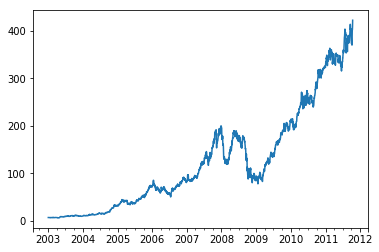

In [158]:
close_px_all = pd.read_csv('examples/stock_px_2.csv', 
                           parse_dates=True, 
                           index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()
close_px.AAPL.plot()

In [159]:
applr_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
applr_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

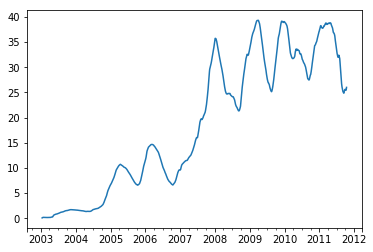

In [160]:
applr_std250.plot()

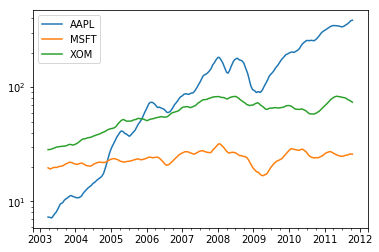

In [162]:
expanding_mean = applr_std250.expanding().mean()
close_px.rolling(60).mean().plot(logy=True)

In [163]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
2003-01-09,7.391667,21.490000,29.273333
2003-01-10,7.387143,21.558571,29.238571
2003-01-13,7.378750,21.633750,29.197500
2003-01-14,7.370000,21.717778,29.194444
2003-01-15,7.355000,21.757000,29.152000


### 指数加权函数

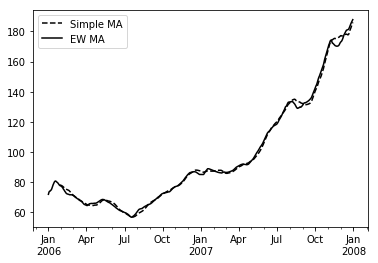

In [168]:
apple_px = close_px.AAPL['2006':'2007']
ma60 = apple_px.rolling(30, min_periods=20).mean()
ewma60 = apple_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

### 二元移动窗口函数

In [169]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

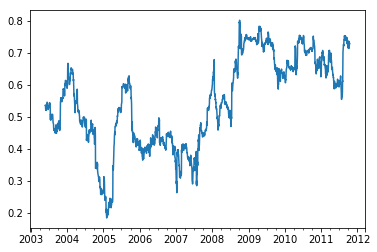

In [170]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

### 用户自定义的移动窗口函数

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


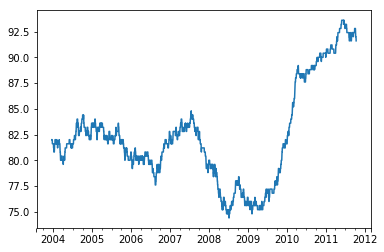

In [172]:
from scipy.stats import percentileofscore

score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot()